<a href="https://colab.research.google.com/github/briandepasquale/transformer/blob/main/Transformer_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

In [2]:
# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [80]:
def generate_periodic_batch(
    batch_size=64,
    seq_len=1000,
    small_lag=100,
    large_lag=200,
    n_freqs=10,
    noise_std=0.05,
    device='cpu'
):
    """
    Generate a batch of periodic signals with *two possible lags* (small or large)
    and additive noise, fully in PyTorch.

    Returns:
        x: (B, T, 1)  input sequences
        y: (B, T, 1)  target sequences (lagged)
        lags: (B,)    integer lag for each example
    """

    # Time axis [0, 2π], shape (T,)
    t = torch.linspace(0, 2 * torch.pi, seq_len, device=device)

    # Random frequencies (B, n_freqs)
    freqs = torch.rand(batch_size, n_freqs, device=device) * 10 + 1   # [1,11]

    # Random phases (B, n_freqs)
    phases = torch.rand(batch_size, n_freqs, device=device) * 2 * torch.pi

    # Expand time axis for broadcasting: (B, n_freqs, T)
    t_expanded = t.unsqueeze(0).unsqueeze(0)  # (1,1,T)
    t_expanded = t_expanded.expand(batch_size, n_freqs, seq_len)

    freqs_expanded = freqs.unsqueeze(-1)     # (B, n_freqs, 1)
    phases_expanded = phases.unsqueeze(-1)   # (B, n_freqs, 1)

    # Periodic signal: sum over n_freqs
    signal_components = torch.sin(freqs_expanded * t_expanded + phases_expanded)
    signal = signal_components.sum(dim=1)  # (B, T)

    # Add Gaussian noise
    if noise_std > 0:
        signal += torch.randn_like(signal) * noise_std

    # 🔥 Sample lags: each example randomly gets either small_lag or large_lag
    choices = torch.tensor([small_lag, large_lag], device=device)
    lags = choices[torch.randint(0, 2, (batch_size,), device=device)]

    # Create y by rolling each sequence individually
    y = torch.zeros_like(signal)
    for i, lag in enumerate(lags):
        y[i] = torch.roll(signal[i], shifts=int(lag.item()))
        #y[i, :lag] = 0.0  # zero out wrapped section to avoid leakage
        y[i, :lag] = torch.randn(lag, device=device)

    # Add channel dimension
    x = signal.unsqueeze(-1)  # (B, T, 1)
    y = y.unsqueeze(-1)       # (B, T, 1)

    # Optional nonlinearity
    y = torch.tanh(y)

    # ✅ Add noise to the outputs
    y = y + torch.randn_like(y) * noise_std

    return x, y, lags

In [181]:
# ======================================================
# 3. Positional Encoding
# ======================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, T, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [237]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2):
        super().__init__()

        self.register_buffer('pos_alpha', torch.tensor(0.1))
        #self.pos_alpha = nn.Parameter(torch.tensor(0.1))  # small initial value
        #self.log_alpha = nn.Parameter(torch.log(torch.tensor(0.1)))  # start at 0.1

        # Input/output projections
        self.in_proj = nn.Linear(1, d_model)
        self.out_proj = nn.Linear(d_model, 1)

        # Positional encoding
        self.pos_enc = PositionalEncoding(d_model)

        # Encoder and decoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

    def forward(self, src, tgt):
        """
        src: (B, T_src, 1) input sequence
        tgt: (B, T_tgt, 1) target sequence (or zeros if teacher forcing is not used)
        """

        # Project to model dimension
        src = self.in_proj(src)
        tgt = self.in_proj(tgt)

        # Add positional encodings
        #src = self.pos_enc(src)
        #tgt = self.pos_enc(tgt)

        #alpha = torch.exp(self.log_alpha)
        pe_src = self.pos_enc.pe[:, :src.size(1)]
        pe_tgt = self.pos_enc.pe[:, :tgt.size(1)]

        # ✅ Add *scaled* positional encodings
        src = src + self.pos_alpha * pe_src
        tgt = tgt + self.pos_alpha * pe_tgt
        #src = src + alpha * self.pos_enc(src)
        #tgt = tgt + alpha * self.pos_enc(tgt)

        # Encode/decode
        memory = self.encoder(src)
        out = self.decoder(tgt, memory)

        # Project back to 1D
        return self.out_proj(out)

In [238]:
n_batches = 3000

In [239]:
model = Seq2SeqTransformer(
    d_model=64,
    nhead=4,
    num_layers=2,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [240]:
loss_history = []

In [241]:
print("Training...")

for step in range(n_batches):
    # Generate training batch
    x, y, _ = generate_periodic_batch()
    x = x.to(device)
    y = y.to(device)

    # Teacher forcing: use zeros as decoder input
    y_in = torch.zeros_like(y)

    # Forward pass through the model
    y_pred = model(x, y_in)  # internally applies in_proj, pos_enc, encoder+decoder

    # Compute loss
    loss = loss_fn(y_pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

Training...
Step 500/3000, Loss: 0.633210
Step 1000/3000, Loss: 0.638140
Step 1500/3000, Loss: 0.623259
Step 2000/3000, Loss: 0.634890
Step 2500/3000, Loss: 0.622092
Step 3000/3000, Loss: 0.637603


In [242]:
# Save both model and optimizer
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_history,   # optional, if you want to keep track
    'step': step                    # optional, to resume exactly at the same step
}, "transformer_checkpoint.pt")

In [243]:
# model = Seq2SeqTransformer(
#     d_model=64,
#     nhead=2,
#     num_layers=2,
# ).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # 2. Load checkpoint
# checkpoint = torch.load("transformer_checkpoint.pt", map_location='cpu')

# # 3. Restore weights and optimizer state
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # 4. Optional: restore other info
# loss_history = checkpoint.get('loss_history', [])
# step = checkpoint.get('step', 0)

# # 5. Choose mode depending on what you're doing
# model.train()   # or model.eval()

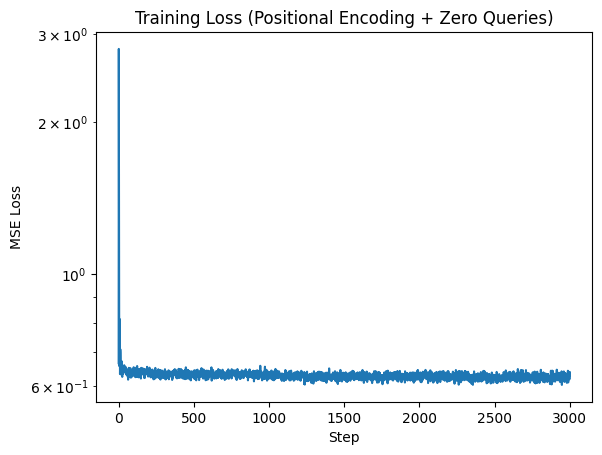

In [244]:
# Plot training curve
plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss (Positional Encoding + Zero Queries)")
plt.show()

In [245]:
model.eval()

# Generate test batch
x_test, y_test, taus = generate_periodic_batch(batch_size=10)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Prepare inputs
y_in = torch.zeros_like(y_test)

layer = model.decoder.layers[0]

with torch.no_grad():
    memory = model.encoder(model.pos_enc(model.in_proj(x_test)))
    #tgt = model.pos_enc(model.in_proj(y_in))
    tgt = model.pos_enc(model.in_proj(y_test))  # teacher forcing

    # run cross-attention only
    _, attn = layer.multihead_attn(tgt, memory, memory,
                                   need_weights=True,
                                   average_attn_weights=False)

print(attn.shape)  # (batch, heads, T_dec, T_enc)

torch.Size([10, 4, 1000, 1000])


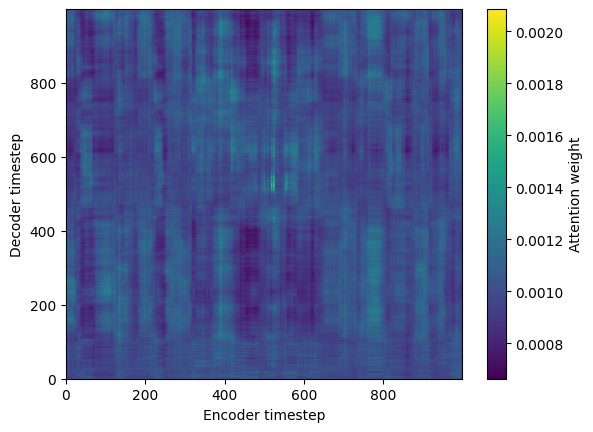

In [246]:
i = 1  # pick a sample index
attn_i = attn[taus == 100, :, :, :].mean(dim=(0,1)).detach().cpu()  # (T_dec, T_enc)
plt.imshow(attn_i, aspect='auto', origin='lower')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep')
plt.ylabel('Decoder timestep')
plt.show()

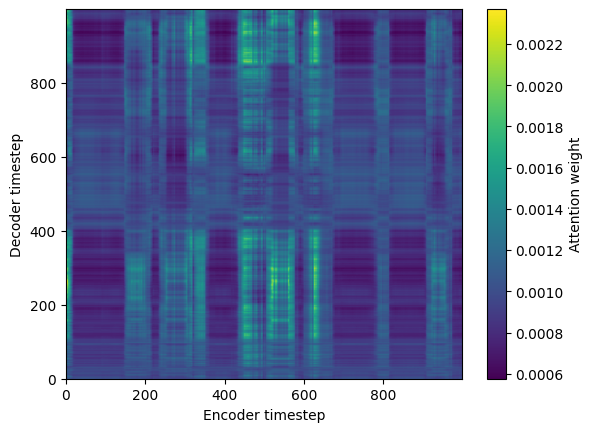

In [247]:
i = 1  # pick a sample index
attn_i = attn[taus == 200, :, :, :].mean(dim=(0,1)).detach().cpu()  # (T_dec, T_enc)
plt.imshow(attn_i, aspect='auto', origin='lower')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep')
plt.ylabel('Decoder timestep')
plt.show()

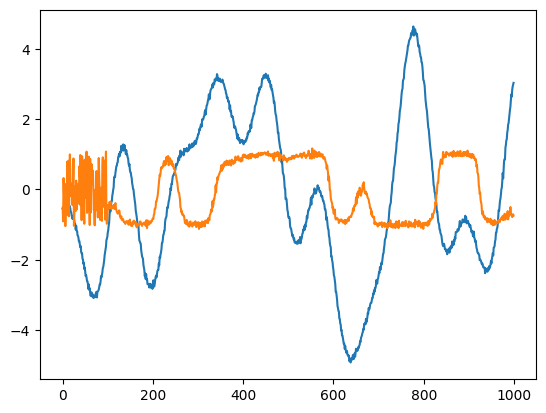

In [248]:
plt.plot(x_test[1].detach().cpu())
plt.plot(y_test[1].detach().cpu())

In [249]:
A = attn.mean(dim=(0, 1))   # (T_dec, T_enc)
ridge_idx = A.argmax(dim=1)          # (T_dec,)

In [255]:
offsets = ridge_idx.float() - torch.arange(
    len(ridge_idx),
    dtype=torch.float,
    device=ridge_idx.device   # ✅ match device
)
mean_offset = offsets[220:].mean()
print(mean_offset.item())

-265.42437744140625


In [256]:
# Pick two different trials
i, j = 0, 3
diff = (attn[i] - attn[j]).abs().mean().item()
print("Mean abs difference between attention maps:", diff)

Mean abs difference between attention maps: 0.0006642856169492006


In [257]:
print((x_test[0] - x_test[1]).abs().mean().item())

3.042468547821045


In [258]:
mem = model.encoder(model.pos_enc(model.in_proj(x_test)))
print((mem[0] - mem[1]).abs().mean().item())

1.1333718299865723


In [259]:
print((y_test[0] - y_test[1]).abs().mean().item())

1.079620599746704


In [260]:
A = attn.mean(dim=(0, 1))  # averaged attention map
ridge_idx = A.argmax(dim=1)
offsets = ridge_idx.float() - torch.arange(len(ridge_idx), device=ridge_idx.device)
print(offsets.mean().item())

-168.99700927734375


In [261]:
Q = model.pos_enc(model.in_proj(y_test))  # (B, T_dec, d)
K = model.encoder(model.pos_enc(model.in_proj(x_test)))  # (B, T_enc, d)

# Compare dot products for trial 0 vs 1
dots0 = torch.matmul(Q[0], K[0].transpose(0,1))
dots1 = torch.matmul(Q[1], K[1].transpose(0,1))
print((dots0 - dots1).abs().mean().item())

9.83005428314209


In [262]:
# Get positional encodings alone for decoder and encoder
Q_pos = model.pos_enc(torch.zeros_like(Q))
K_pos = model.pos_enc(torch.zeros_like(K))

dots_pos = torch.matmul(Q_pos[0], K_pos[0].transpose(0,1))
dots_full = torch.matmul(Q[0], K[0].transpose(0,1))

print("Pos-only mean abs:", dots_pos.abs().mean().item())
print("Full mean abs:", dots_full.abs().mean().item())

Pos-only mean abs: 10.700875282287598
Full mean abs: 7.351121425628662


In [263]:
# Build content-only Qc, Kc by subtracting the positional component you add
Qc = Q - model.pos_enc(torch.zeros_like(Q))  # if pos_enc(x) ignores content scale
Kc = K - model.pos_enc(torch.zeros_like(K))

A_content = torch.matmul(
    torch.nn.functional.normalize(Qc, dim=-1),
    torch.nn.functional.normalize(Kc, dim=-1).transpose(-1, -2)
).softmax(dim=-1)

# Compare per-trial differences now:
print((A_content[0] - A_content[1]).abs().mean().item())

0.00015092690591700375


In [264]:
with torch.no_grad():
    zeros_src = torch.zeros_like(x_test)
    zeros_tgt = torch.zeros_like(y_test)
    mem_pos = model.encoder(model.pos_enc(model.in_proj(zeros_src)))
    tgt_pos = model.pos_enc(model.in_proj(zeros_tgt))
    _, attn_pos_only = layer.multihead_attn(tgt_pos, mem_pos, mem_pos, need_weights=True, average_attn_weights=False)

print((attn_pos_only[0] - attn_pos_only[1]).abs().mean().item())

0.0


In [266]:
# After adding α
print("Alpha:", model.pos_alpha.item())

Q = model.in_proj(y_test)
K = model.in_proj(x_test)
Q_full = Q + model.pos_alpha * model.pos_enc(Q)
K_full = K + model.pos_alpha * model.pos_enc(K)

Q_pos = model.pos_alpha * model.pos_enc(torch.zeros_like(Q))
K_pos = model.pos_alpha * model.pos_enc(torch.zeros_like(K))

print("Pos-only mean abs:", (Q_pos[0] @ K_pos[0].T).abs().mean().item())
print("Full mean abs:", (Q_full[0] @ K_full[0].T).abs().mean().item())


Alpha: 0.10000000149011612
Pos-only mean abs: 0.10700875520706177
Full mean abs: 40.795345306396484
